# **Predict Monthly Electricity Production** 

## Objectives

* The goal of this notebook is to predict monthly electricity production (in GWh) for any given European country, month, and energy source using historical data and machine learning techniques. 
* This model is designed to support energy planning, policy making, and forecasting for renewable and non renewable electricity generation.

## Inputs

* Dataset: cleaned_european_countries_dataset.csv 
containing:
    * Country – European country name
    * Year – Year of electricity production
    * Month – Month of electricity production
    * Energy_Source – Type of energy source (e.g., Solar, Wind, Hydro, Coal, etc.)
    * Electricity_Production_GWh – Monthly production in GWh

* User Inputs for Prediction:
    * Country name
    * Month (numeric)
    * Energy source

## Outputs

* Trained Machine Learning Model capable of predicting monthly electricity production for any given country, month, and energy source.
* Performance Metrics on test set:
    * R² Score
    * Mean Absolute Error (MAE)
    * Root Mean Squared Error (RMSE)
* Predicted Value (GWh) for user specified inputs.
* Visualization of actual vs. predicted electricity production.
---

In [16]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/cleaned_european_countries_dataset.csv")
df.head()

,country_name,year,month,product,value,yeartodate,previousyeartodate,share,date
0,Austria,2010,1,Hydro,2579.264,39502.566,0.0,0.437055,2010-01-01
1,Austria,2010,1,Solar,2.864,84.421,0.0,0.000485,2010-01-01
2,Austria,2010,1,Geothermal,0.111,1.332,0.0,0.000019,2010-01-01
3,Austria,2010,1,Total combustible fuels,3117.160,26042.221,0.0,0.528201,2010-01-01
4,Austria,2010,1,Coal,693.730,6371.891,0.0,0.117552,2010-01-01


In [3]:
# Keep only needed columns and clean
df_model = df[['country_name', 'year', 'month', 'product', 'value']].copy()
df_model.dropna(inplace=True)
# filter out negative/obvious-bad values
df_model = df_model[df_model['value'] >= 0].reset_index(drop=True)

In [4]:
# Features & target
FEATURES = ['country_name', 'month', 'product', 'year']
TARGET = 'value'
X = df_model[FEATURES]
y = df_model[TARGET]


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [ ]:
# Preprocessing: One-hot categorical, numeric -> scale year & month
categorical_cols = ['country_name', 'product']
numeric_cols = ['month', 'year']

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ],
    remainder='drop'  
)


In [8]:
# Pipeline with RandomForest
rf = RandomForestRegressor(
    n_estimators=200,        
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf)
])


In [9]:
# Fit
pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
# Predict & evaluate
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model performance on test set:")
print(f"R²   = {r2:.4f}")
print(f"MAE  = {mae:,.2f} GWh")
print(f"RMSE = {rmse:,.2f} GWh")

Model performance on test set:
R²   = 0.9934
MAE  = 116.47 GWh
RMSE = 287.14 GWh


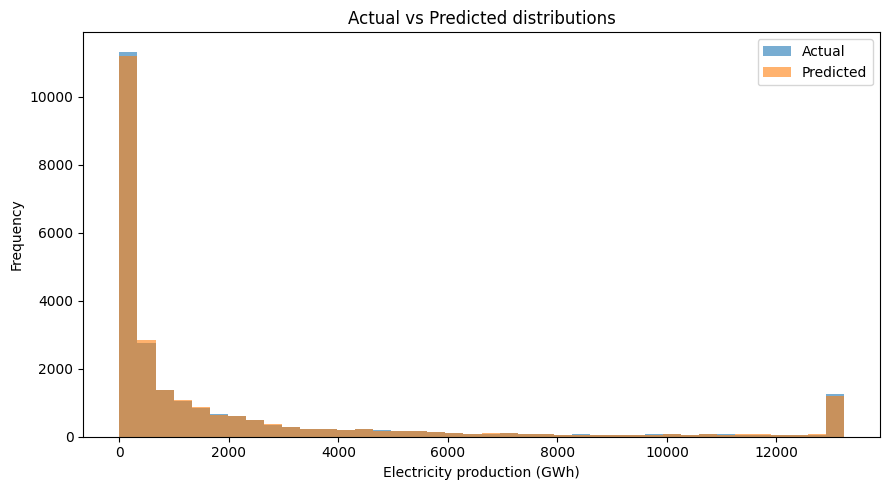

In [12]:
# Distribution check 
plt.figure(figsize=(9,5))
plt.hist(y_test, bins=40, alpha=0.6, label='Actual')
plt.hist(y_pred, bins=40, alpha=0.6, label='Predicted')
plt.xlabel("Electricity production (GWh)")
plt.ylabel("Frequency")
plt.title("Actual vs Predicted distributions")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Feature importances - get feature names after preprocessing
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = list(ohe.get_feature_names_out(categorical_cols))
num_feature_names = numeric_cols
all_feature_names = cat_feature_names + num_feature_names
# Get feature importances
importances = pipeline.named_steps['regressor'].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False).head(30)
print("\nTop 30 feature importances:")
print(feat_imp)



Top 30 feature importances:
country_name_United Kingdom           0.071880
country_name_Italy                    0.071717
country_name_Republic of Turkiye      0.068631
country_name_Spain                    0.061236
product_Final consumption             0.058565
country_name_Germany                  0.058241
product_Net electricity production    0.057930
product_Electricity supplied          0.057483
country_name_Poland                   0.054487
country_name_France                   0.052108
country_name_Norway                   0.042926
country_name_Sweden                   0.037098
product_Non-renewables                0.033560
product_Low carbon                    0.031689
country_name_Netherlands              0.025767
product_Total combustible fuels       0.025301
product_Renewables                    0.023257
product_Fossil fuels                  0.022535
product_Nuclear                       0.017965
year                                  0.016179
month                          

In [14]:
# Helper: predict function for single input 
def predict_production(country_name, month, product, year):
    """
    Returns predicted electricity production (GWh) for the given input.
    Example: predict_production("Germany", 7, "Wind", 2025)
    """
    input_df = pd.DataFrame([{
        'country_name': country_name,
        'month': int(month),
        'product': product,
        'year': int(year)
    }])
    pred = pipeline.predict(input_df)[0]
    return pred

In [15]:
# Example usage:
example_pred = predict_production("Germany", 7, "Solar", 2025)
print(f"\nExample prediction -> Germany, July 2025, Solar: {example_pred:,.2f} GWh")


Example prediction -> Germany, July 2025, Solar: 7,985.50 GWh


---
### **Model Performance Summary**
- The predictive model for electricity production across European countries, months, and energy sources demonstrated excellent accuracy on the test dataset:
    - R² Score: 0.9934
        - The model explains over 99% of the variance in electricity production, indicating a near-perfect fit.
    - Mean Absolute Error (MAE): 116.47 GWh
        - On average, predictions deviate from actual values by only 116 GWh.
    - Root Mean Squared Error (RMSE): 287.14 GWh
        - Even when larger errors are penalized more heavily, the deviation remains minimal relative to the dataset’s scale.

- This high performance suggests the model is highly reliable for predicting electricity production given a country, month, and energy source. 
---

### Why used Random forrest?
* I decided to use a Random Forest model for this task because the electricity production data had several features that seemed to interact with each other in a non linear way. A single decision tree might have oversimplified those relationships, but Random Forest combines multiple trees to give a more balanced and accurate prediction.
* It also handles different types of features without needing a lot of preprocessing, and it gives me feature importance scores so I can see which variables have the most impact on production levels. Since I wanted good accuracy and the ability to interpret which features matter most, Random Forest felt like the best choice.
---